In [27]:
import sklearn
import pandas as pd
import numpy as np
import math
import warnings
# plotting
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set(context='paper', style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# preproc
from scipy.stats import zscore

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# grid search CV for model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# metrics for classification
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import make_scorer

# post-processing 
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV, _CalibratedClassifier


# statistical reporting
import statsmodels.api as sm

# import custom functions from my package
import sys
import os
sys.path.append("../")
from mcc_metastasis import modeling 
from mcc_metastasis import custom_plots
from mcc_metastasis import data_cleaning

RANDOM = 0
figure_path = "../figures/TNM_outcome/NCDB_5_features/"

## 1. Prep data

- load data 

In [7]:
# OPEN DATA 
df = pd.read_csv("../data/cleaned/NCDB_cleaned_all_cases.csv")
## select relevant variables: removed sex and tumor site
df = df [[ 'tumor_lymphocytes', 'lymph_vasc_invasion', 'TNM_positive']]

# clean up 
df['TNM_negative'] = df.TNM_positive.replace({0:1, 1:0})
df = df.drop(columns = 'TNM_positive')
df.TNM_negative.value_counts()


1.0    5043
0.0     713
Name: TNM_negative, dtype: int64

### data version 1: drop all cases with missing data

In [8]:
df_complete = df.dropna(axis = 0)
df_complete.shape

(1250, 3)

### data version 2: retain samples using imputation


In [9]:
data_cleaning.get_missingness_table(df)

Missingness of features


,index,Missing
0,tumor_lymphocytes,12260
1,lymph_vasc_invasion,10026
2,TNM_negative,9192


In [11]:
# what did i remove? sex, tumor site, 
df2 = df[(df.TNM_negative.isnull() == False) &
       (df.tumor_lymphocytes.isnull() == False)]

# how many would we need to impute?
data_cleaning.get_missingness_table(df2)

Missingness of features


,index,Missing
0,tumor_lymphocytes,0
1,lymph_vasc_invasion,385
2,TNM_negative,0


### Impute missing data 
- imputing lymph vasc invasion, tumor_size
- don't want to include outcome in imputation process...

In [12]:
outcome = df2['TNM_negative'].reset_index(drop = True)
features = df2.drop(columns =[ 'TNM_negative'])
imputer = KNNImputer()
imputed_features = pd.DataFrame(imputer.fit_transform(features), columns = features.columns)
imputed_df = pd.concat([imputed_features, outcome], axis = 1)
imputed_df.shape

(1635, 3)

In [14]:
# checkL has non-binary values
imputed_features.lymph_vasc_invasion.value_counts()

0.0    1216
1.0     357
0.2      62
Name: lymph_vasc_invasion, dtype: int64

### Define cross validation
- split data into train-val and hold-out test sets 
- stratified CV folds, 3 folds repeated 5x with random sampling

In [15]:
 # make cross val folds - 
CV_folds =  RepeatedStratifiedKFold(n_splits = 3, 
                                    n_repeats =  5,  
                                    random_state = 0)
 

### Define Models

In [16]:
LogReg= LogisticRegression(class_weight = 'balanced', 
                              max_iter = 1000,
                              penalty = 'l1', 
                              solver = 'liblinear', 
                             random_state = RANDOM)
SVM = SVC (kernel = "rbf",
          class_weight = 'balanced',
          probability = True,
          random_state = RANDOM)

DT = DecisionTreeClassifier(class_weight = "balanced",
                           random_state = RANDOM)
RF = RandomForestClassifier(class_weight = 'balanced',
                           random_state = RANDOM)

#import lightgbm as lgb
#LGB = lgb(objective = "binary", early_stopping_rounds = 5)
#from xgboost import XGBClassifier 
# n esttimattors = number of training iterations.
#xgb = XGBClassifier(objective='binary:logistic', n_estimators = 70, seed = 101)

### Tune the model 
- grid search with different levels of regularization (parameter C, inverse of alpha in R)
- smaller values of C = larger values of alpha = more regularization
- applied to cross-validation folds 
- get several metrics out! 


In [19]:
# larger C = less regularization
# default = 1.0 
param_grid_C = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100] }
param_grid_tree = {# 'max_depth': [25], # max depth of the tree
                 'model__min_samples_leaf' : [ 10,  50, 100], # minimum samples contained at each end node
                 'model__min_samples_split': [10,  50, 100] # how small is  a node allowed to be before it's split
                  }
param_grid_RF = { #'max_depth': [25], # max depth of the tree
                 'model__min_samples_leaf' : [10, 50, 100], # minimum samples contained at each end node
                 'model__min_samples_split': [10, 50, 100], # how small is  a node allowed to be before it's split
                  'model__n_estimators': [100, 500] # number of trees - hw many resampled iterations.
               }
param_grid_boost = {
                    'num_leaves': [10, 20, 30]
}

score_list = {'acc': 'accuracy',
              'precision' : 'precision',
              'recall': 'recall', 
              'f1': 'f1',
              'roc_auc': 'roc_auc', 
             'brier_score': 'brier_score_loss'}

In [21]:
# define options for looop 
model_choices = [LogReg, SVM, DT, RF]
model_names =  ['LogReg', 'SVM', 'Decision Tree', 'Random Forest',
                    'LogReg', 'SVM', 'Decision Tree', 'Random Forest']

param_grid_list = [param_grid_C, param_grid_C, param_grid_tree, param_grid_RF] 

datasets = [df_complete, imputed_df]
dataset_names = ["complete", "imputed"]


grid_results = pd.DataFrame()
i = 0
for data in datasets:

    features = data.drop(columns = ['TNM_negative'])
    outcome = data['TNM_negative'].reset_index(drop = True)
    # split into train and test set 
    X_trainval, X_test, y_trainval, y_test = train_test_split(features, 
                                                              outcome,
                                                              stratify =outcome,
                                                              test_size = 0.3)
    # further split so only doing CV on the training, validattion for ccalibration
    X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                     y_trainval,
                                                     stratify = y_trainval, 
                                                     test_size = 0.3)
    
    j  = 0 
    for model in model_choices:
        # NO PREPROCESSING REQUIRED.
        pipe = Pipeline(steps = [ ('model', model)])
                                                              
        grid = GridSearchCV(pipe,
                    param_grid = param_grid_list[j],
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)                                                      
        grid.fit(X_train, y_train)        
        results = pd.DataFrame(grid.cv_results_)
        results['model'] = model_names[j]
        results['dataset'] = dataset_names[i]
        print(dataset_names[i])
        print(model_names[j])
        grid_results = pd.concat([grid_results, results], ignore_index = True)
         
        j = j+1
    i = i+1


complete
LogReg
complete
SVM
complete
Decision Tree
complete
Random Forest
imputed
LogReg
imputed
SVM
imputed
Decision Tree
imputed
Random Forest


In [24]:
# get log  of C for easier visualization
grid_results['param_model__C']= grid_results.param_model__C.astype('float')
grid_results['log_C'] = grid_results.param_model__C.map(lambda x: math.log10(x))

# clean up dataframe so only have mean scores 
grid_results = grid_results[['model', 'dataset', 'param_model__C', 'log_C', 'param_model__n_estimators',
                             'param_model__min_samples_leaf', 'param_model__min_samples_split',
                             'mean_train_f1', 'mean_test_f1', 
                             'mean_train_precision', 'mean_test_precision',
                             'mean_train_recall', 'mean_test_recall', 
                             'mean_train_acc', 'mean_test_acc', 
                             'mean_train_roc_auc', 'mean_test_roc_auc', 
                             'mean_train_brier_score', 'mean_test_brier_score']]
grid_results.to_csv("../model_output/TNM_outcome/grid_results_NCDB_5_selected_features.csv")

In [25]:
# reshape data from wide to long
grid_results_long = pd.melt(grid_results, 
                            id_vars = ['model', 'dataset', 'param_model__C', 'log_C','param_model__n_estimators',
                                 'param_model__min_samples_leaf', 'param_model__min_samples_split'], 
                            value_vars = ['mean_train_f1', 'mean_test_f1', 
                                          'mean_train_precision', 'mean_test_precision',
                                          'mean_train_recall', 'mean_test_recall',
                                          'mean_train_acc','mean_test_acc', 
                                          'mean_train_roc_auc', 'mean_test_roc_auc'],
                                          
                           var_name = 'metric', 
                           value_name = 'score')

# add indicator for train vs. tteam
#apply(lambda x: 0 if x == 1 else 1)
grid_results_long['TrainVal'] = grid_results_long.metric.str.contains("train").\
apply(lambda x: "Train" if x == True else "Validation")
# get rid of prefix 
grid_results_long["metric"] = grid_results_long.metric.str.replace('mean_test_', "").str.replace('mean_train_', "")
grid_results_long.columns

Index(['model', 'dataset', 'param_model__C', 'log_C',
       'param_model__n_estimators', 'param_model__min_samples_leaf',
       'param_model__min_samples_split', 'metric', 'score', 'TrainVal'],
      dtype='object')

### Visualize learning curves
- as a function of train vs validation sets 
- can see whether model is over-fit or underfit 

<Figure size 576x720 with 0 Axes>

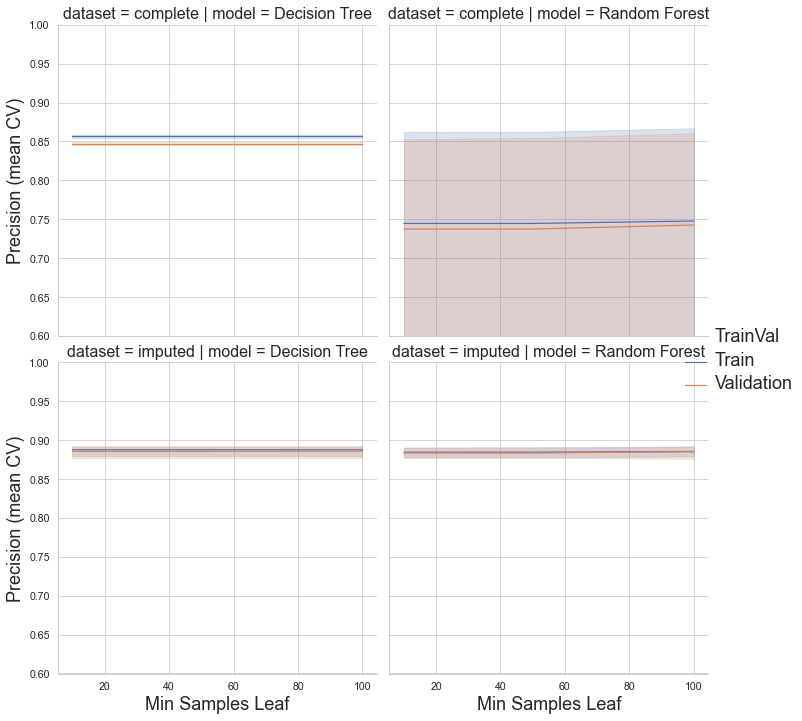

In [39]:
# figure of model comparisons on training  
plt.figure(figsize = (8, 10))
g = sns.relplot(data = grid_results_long[(grid_results_long.metric == "precision") & 
                                        ((grid_results_long.model == "Decision Tree") |
                                        (grid_results_long.model == "Random Forest"))], 
                x = "param_model__min_samples_split", y = 'score', 
                color = "black", hue = "TrainVal",  
                kind = "line",  col = "model", row = "dataset")
g.set_xlabels("Min Samples Leaf", size = 18)
g.set_ylabels("Precision (mean CV)", size = 18)
plt.setp(g._legend.get_title(), fontsize = 18)
plt.setp(g._legend.get_texts(), fontsize = 18)
g.set_titles(size = 16)
g.set(ylim = (0.6, 1.0))

plt.savefig(os.path.join(figure_path, "Grid_CV_Tree_models_learning_curves_precision.png"))

### all of the models are hitting the same ceiling with precision scores! 

<Figure size 576x720 with 0 Axes>

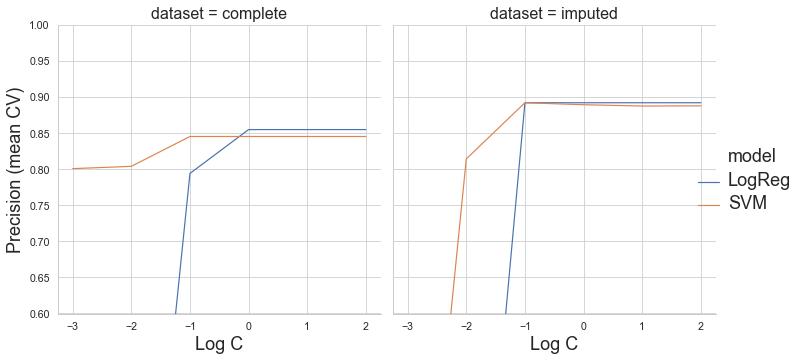

In [40]:
# figure of model comparisons on training  
plt.figure(figsize = (8, 10))
g = sns.relplot(data = grid_results_long[(grid_results_long.metric == "precision") & 
                                        ((grid_results_long.model != "Decision Tree") &
                                        (grid_results_long.model != "Random Forest")) & 
                                        (grid_results_long.TrainVal == "Validation")], 
                x = "log_C", y = 'score', 
                color = "black", hue = "model",  
                kind = "line",  col =  "dataset")
g.set_xlabels("Log C", size = 18)
g.set_ylabels("Precision (mean CV)", size = 18)
g.set(ylim = (0.6, 1.0))
plt.setp(g._legend.get_title(), fontsize = 18)
plt.setp(g._legend.get_texts(), fontsize = 18)
g.set_titles(size = 16)
plt.savefig(os.path.join(figure_path, "Grid_CV_Linear_models_learning_curves_precision.png"))

In [41]:
best_metric = grid_results['mean_test_precision'].max()
match_best = grid_results['mean_test_precision'] == best_metric
best_model = grid_results[match_best]
print("Best Model Precision %0.3f" % best_metric)
display(best_model)


Best Model Precision 0.892


,model,dataset,param_model__C,log_C,param_model__n_estimators,param_model__min_samples_leaf,param_model__min_samples_split,mean_train_f1,mean_test_f1,mean_train_precision,mean_test_precision,mean_train_recall,mean_test_recall,mean_train_acc,mean_test_acc,mean_train_roc_auc,mean_test_roc_auc,mean_train_brier_score,mean_test_brier_score
41,LogReg,imputed,0.1,-1.0,NaN,NaN,NaN,0.736988,0.736863,0.891812,0.891932,0.628052,0.628062,0.632502,0.632506,0.662226,0.658289,-0.241343,-0.242169
42,LogReg,imputed,1.0,0.0,NaN,NaN,NaN,0.736988,0.736863,0.891812,0.891932,0.628052,0.628062,0.632502,0.632506,0.661676,0.656695,-0.224833,-0.225656
43,LogReg,imputed,10.0,1.0,NaN,NaN,NaN,0.736988,0.736863,0.891812,0.891932,0.628052,0.628062,0.632502,0.632506,0.661676,0.656695,-0.223646,-0.224470
44,LogReg,imputed,100.0,2.0,NaN,NaN,NaN,0.736988,0.736863,0.891812,0.891932,0.628052,0.628062,0.632502,0.632506,0.661676,0.656695,-0.223533,-0.224356
47,SVM,imputed,0.1,-1.0,NaN,NaN,NaN,0.736988,0.736863,0.891812,0.891932,0.628052,0.628062,0.632502,0.632506,0.650348,0.634155,-0.140411,-0.141017
54,Decision Tree,imputed,NaN,NaN,NaN,50,10,0.736988,0.736863,0.891812,0.891932,0.628052,0.628062,0.632502,0.632506,0.664975,0.659203,-0.222690,-0.224304
55,Decision Tree,imputed,NaN,NaN,NaN,50,50,0.736988,0.736863,0.891812,0.891932,0.628052,0.628062,0.632502,0.632506,0.664975,0.659203,-0.222690,-0.224304
56,Decision Tree,imputed,NaN,NaN,NaN,50,100,0.736988,0.736863,0.891812,0.891932,0.628052,0.628062,0.632502,0.632506,0.664975,0.659203,-0.222690,-0.224304
66,Random Forest,imputed,NaN,NaN,100,50,10,0.736988,0.736863,0.891812,0.891932,0.628052,0.628062,0.632502,0.632506,0.661802,0.661703,-0.224535,-0.225204
67,Random Forest,imputed,NaN,NaN,500,50,10,0.736988,0.736863,0.891812,0.891932,0.628052,0.628062,0.632502,0.632506,0.662256,0.658860,-0.225214,-0.225984


### Calibrate probabilties with validation set 

In [42]:
best_LR_model = LogisticRegression(class_weight = 'balanced', 
                              max_iter = 1000,
                              penalty = 'l1', 
                               C = 100,
                              solver = 'liblinear', 
                             random_state = RANDOM)
# add extra step of calibration 
Isotonic = CalibratedClassifierCV(best_LR_model, method = "isotonic", cv = 3)

Sigmoid = CalibratedClassifierCV(best_LR_model, method = "sigmoid", cv = 3)


In [43]:

# define scores to get from each model 
def get_scores(y_test, y_pred):
        scores = pd.DataFrame({ "metrics"  : ["precision", "recall", "roc_auc",
                                          "accuracy", "f1 score", "pr_auc", "brier_score"],
                                "scores" : [precision_score(y_test, y_pred), 
                                           recall_score(y_test, y_pred),
                                            roc_auc_score(y_test, y_pred),
                                            accuracy_score(y_test, y_pred),
                                           f1_score(y_test, y_pred), 
                                           average_precision_score(y_test, y_pred), 
                                           brier_score_loss (y_test, y_pred)]
                               })
        return (scores)


In [55]:
# define options for looop 
model_choices = [best_LR_model, Sigmoid, Isotonic]
model_names = ['RF', 'Sigmoid', 'Isotonic']

calibrate_results = pd.DataFrame()
data = imputed_df
features = data.drop(columns = ['TNM_negative'])
outcome = data['TNM_negative'].reset_index(drop = True)
    # split into train and test set 
X_trainval, X_test, y_trainval, y_test = train_test_split(features, 
                                                              outcome,
                                                              stratify =outcome,
                                                              test_size = 0.33,
                                                              random_state = 0)
    # split further for extra validation set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, 
                                                         y_trainval, 
                                                         test_size = 0.33,
                                                         stratify = y_trainval,
                                                         random_state = 0)

# No calibration 
best_LR_model.fit(X_train, y_train)        
LR_y_val_probs = best_LR_model.predict_proba(X_val)[:,1]
LR_y_val_pred = best_LR_model.predict(X_val)
LR_scores = pd.DataFrame(get_scores(y_val, LR_y_val_pred))
LR_scores['model'] = 'LR'
cm = confusion_matrix(y_val, LR_y_val_pred)
cm

array([[ 43,  22],
       [108, 189]])

In [56]:

# with calibration
Sigmoid.fit(X_train, y_train)        
Sigmoid_y_val_probs = Sigmoid.predict_proba(X_val)[:,1]
Sigmoid_y_val_pred = Sigmoid.predict(X_val)
Sigmoid_scores = pd.DataFrame(get_scores(y_val, Sigmoid_y_val_pred))
Sigmoid_scores['model'] = 'Sigmoid'
    # with calibration
Isotonic.fit(X_train, y_train)        
Isotonic_y_val_probs = Isotonic.predict_proba(X_val)[:,1]
Isotonic_y_val_pred = Isotonic.predict(X_val)
Isotonic_scores = pd.DataFrame(get_scores(y_val, Isotonic_y_val_pred))
Isotonic_scores['model'] = 'Isotonic'


,metrics,scores,model
6,brier_score,0.359116,LR
13,brier_score,0.179558,Isotonic
20,brier_score,0.179558,Sigmoid


### compare brier score after calibration

In [69]:

# isotonic has best brier score 
calibrate_results = pd.concat([LR_scores, Isotonic_scores, Sigmoid_scores], ignore_index = True)
calibrate_results[calibrate_results.metrics == "brier_score"]


,metrics,scores,model
6,brier_score,0.359116,LR
13,brier_score,0.820370,NaN
20,brier_score,0.179558,Sigmoid


### plot calibration

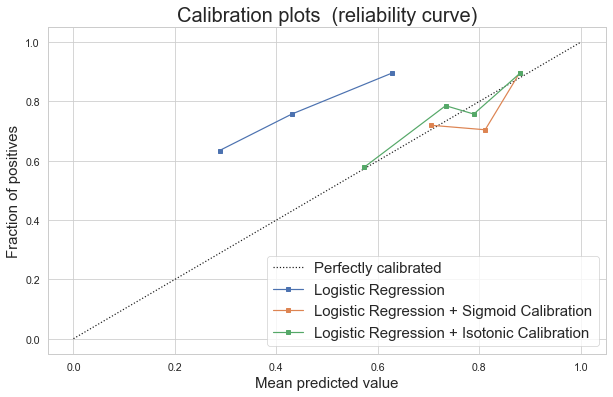

In [71]:
    
#figure_path = "NCDB_5_features/"
fig = plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, LR_y_val_probs, n_bins = 8)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = "Logistic Regression")
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, Sigmoid_y_val_probs, n_bins = 8)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = "Logistic Regression + Sigmoid Calibration")
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, Isotonic_y_val_probs, n_bins = 8)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = "Logistic Regression + Isotonic Calibration")

plt.xlabel("Mean predicted value", size = 15)
plt.ylabel("Fraction of positives", size = 15)
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right", fontsize = 15)
plt.title('Calibration plots  (reliability curve)', size = 20)
plt.savefig(os.path.join(figure_path, "Calibration_validation_plot.png"))

### Results with calibrated model, default threshold
- all patients are predicted for positive class.

In [77]:
Isotonic_y_val_probs = Isotonic.predict_proba(X_val)[:,1]
Isotonic_y_val_pred = Isotonic.predict(X_val)
cm = confusion_matrix(y_val, Isotonic_y_val_pred)
display(cm)
val_scores = pd.DataFrame(get_scores(y_val, Isotonic_y_val_pred))
display(val_scores)

array([[  0,  65],
       [  0, 297]])

,metrics,scores
0,precision,0.820442
1,recall,1.000000
2,roc_auc,0.500000
3,accuracy,0.820442
4,f1 score,0.901366
5,pr_auc,0.820442
6,brier_score,0.179558


### Results with calibrated model, adjust threshold

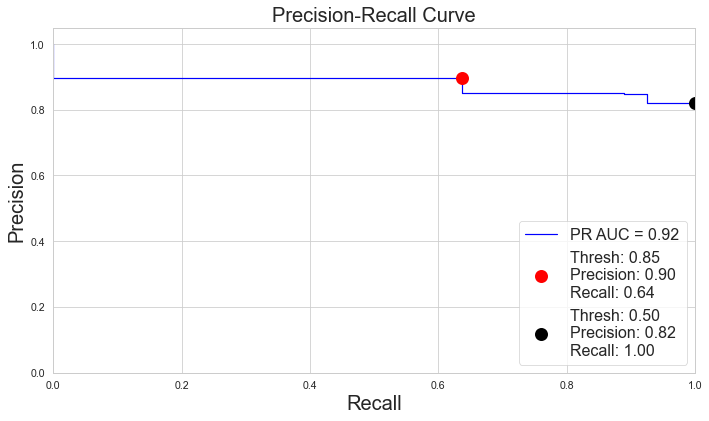

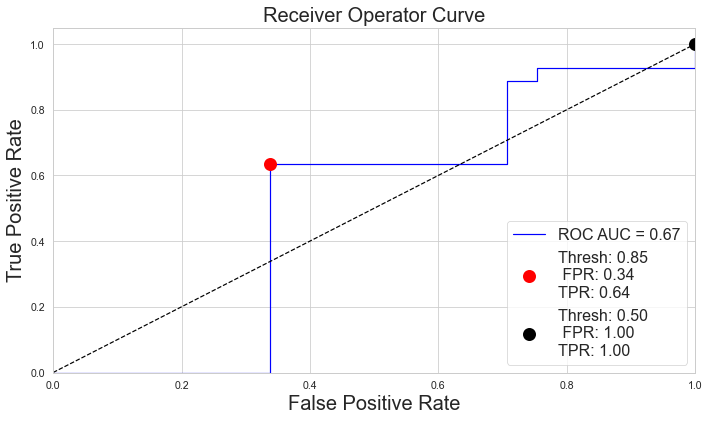

In [73]:
key_thresh = 0.85

custom_plots.plot_pr_curve(y_val, Isotonic_y_val_probs, key_thresh, 
                           filename = os.path.join(figure_path,"validation_PR_curve.png"))
custom_plots.plot_roc_curve(y_val, Isotonic_y_val_probs, key_thresh, 
                           filename = os.path.join(figure_path,"validation_ROC_curve.png"))

In [79]:

Isotonic_y_val_pred_adjusted =  Isotonic_y_val_probs > key_thresh
cm = confusion_matrix(y_val, Isotonic_y_val_pred_adjusted)
display(cm)
val_scores_adjusted = pd.DataFrame(get_scores(y_val, Isotonic_y_val_pred_adjusted))
display(val_scores_adjusted)

array([[ 43,  22],
       [108, 189]])

,metrics,scores
0,precision,0.895735
1,recall,0.636364
2,roc_auc,0.648951
3,accuracy,0.640884
4,f1 score,0.744094
5,pr_auc,0.868355
6,brier_score,0.359116


### Final model evaluation with logistic reg & isotonic calibration
- evaluate on hold out test set

In [74]:

Isotonic_y_test_probs = Isotonic.predict_proba(X_test)[:,1]
Isotonic_y_test_pred = Isotonic.predict(X_test)
Isotonic_y_test_pred_adjusted =  Isotonic_y_test_probs > key_thresh
Isotonic_scores = pd.DataFrame(get_scores(y_test, Isotonic_y_test_pred_adjusted))

Isotonic_scores.to_csv("../model_output/TNM_outcome/final_calibrated_logreg_test_scores.csv")
Isotonic_scores


,metrics,scores
0,precision,0.898361
1,recall,0.618510
2,roc_auc,0.649461
3,accuracy,0.629630
4,f1 score,0.732620
5,pr_auc,0.868608
6,brier_score,0.370370


../mcc_metastasis/modeling.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['Mets', 'No Mets'])
../mcc_metastasis/modeling.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['Mets', 'No Mets'])


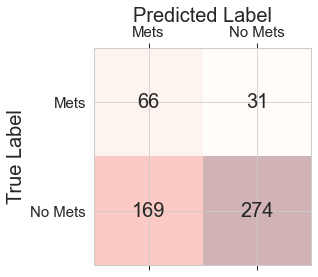

0.012396694214876033

In [75]:
cm = confusion_matrix(y_test, Isotonic_y_test_pred_adjusted)

modeling.pretty_cm(cm, os.path.join(figure_path, "Test_confusion_matrix_adjusted.png"))

17/(595 + 17)
3/ (239+3)


### conclusions
- 1/3 of patients with metastasis would be miss-classified ... not good!